# Loading LSTM from training notebook

In [9]:
import torch
import pickle

import sys
sys.path.append('../')  # Go up to src/ directory
from models import LSTM_model

model = LSTM_model(input_size=14)  # 14 features now (was 9)
model.load_state_dict(torch.load('lstm_model.pth'))
scaler_X, scaler_y = pickle.load(open('scalers.pkl', 'rb'))

# Evaluate and plot

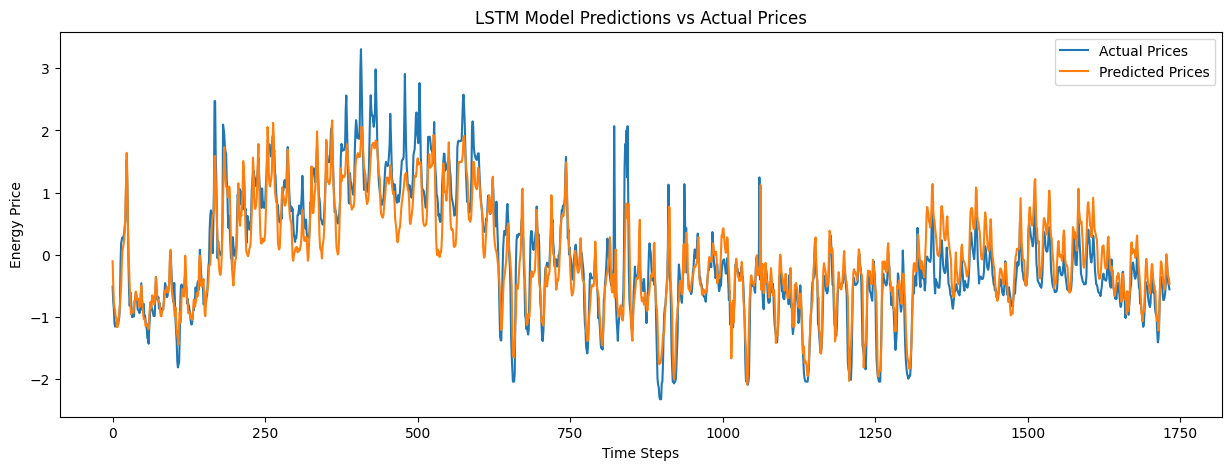

In [10]:
import numpy as np
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

from dataset import EnergyPriceDataset, load_and_preprocess_energy_data

df = load_and_preprocess_energy_data('../../data/energy_data.csv')

feature_cols = [
    'Hour', 'day_nr', 'week_nr', 'year', 'month',
    'day_of_year_sin', 'day_of_year_cos',
    'wind_forecast_dah_mw', 'consumption_forecast_dah_mw',
    'temp_forecast_dah_celcius', 'temp_norm_celcius',
    'heating_demand_interaction', 'temp_deviation',
    'spot_lag1'
]
target_col = 'spot'

split_idx = int(len(df) * 0.8)
train_df = df[:split_idx]
test_df = df[split_idx:]

test_features = scaler_X.transform(test_df[feature_cols])
test_targets = scaler_y.transform(test_df[[target_col]])

sequence_length = 24 # 24 = one day, 168 = one week
test_dataset = EnergyPriceDataset(test_features, test_targets, sequence_length)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        pred = model(X_batch)
        predictions.extend(pred.squeeze().tolist())
        actuals.extend(y_batch.tolist())

predictions = np.array(predictions)
actuals = np.array(actuals)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(actuals, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.legend()
plt.title('LSTM Model Predictions vs Actual Prices')
plt.xlabel('Time Steps')
plt.ylabel('Energy Price')
plt.show()

## OGD on the output

In [25]:
from OGD import OGD_Predictor

predictions_unscaled = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_unscaled = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()

ogd = OGD_Predictor(alpha=0.1, eta=1, q_init=50)

for t in range(len(predictions_unscaled)):
    y_pred = predictions_unscaled[t]
    y_true = actuals_unscaled[t]
    
    lower, upper = ogd.get_interval(y_pred)
    covered = ogd.update(y_pred, y_true)
    
    if t % 100 == 0:
        error = abs(y_true - y_pred)
        width = 2 * ogd.q
        threshold = ogd.q
        
    if t % 100 == 0:
        lower, upper = ogd.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={ogd.q:.2f}")

    if t == len(predictions_unscaled) - 1:
        lower, upper = ogd.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={ogd.q:.2f}")

print("\n ")
print(f"Coverage Rate: {ogd.get_coverage_rate():.3f} (Target: 0.900)")
print(f"Final Threshold: {ogd.q:.2f}")
print(f"Average Width: {np.mean(ogd.threshold_history)*2:.2f}")

misses = sum(1 for c in ogd.coverage_history if not c)
print(f"Total Misses: {misses} out of {len(ogd.coverage_history)}")

t=0: [131.47, 231.27], pred=181.37, true=143.37, covered=True, q=49.90
t=100: [76.95, 160.75], pred=118.85, true=120.30, covered=True, q=41.90
t=200: [123.31, 219.11], pred=171.21, true=189.85, covered=True, q=47.90
t=300: [150.16, 253.96], pred=202.06, true=218.50, covered=True, q=51.90
t=400: [280.32, 392.12], pred=336.22, true=386.37, covered=True, q=55.90
t=500: [272.88, 400.68], pred=336.78, true=369.32, covered=True, q=63.90
t=600: [253.30, 387.10], pred=320.20, true=344.11, covered=True, q=66.90
t=700: [74.91, 210.71], pred=142.81, true=166.65, covered=True, q=67.90
t=800: [17.70, 133.50], pred=75.60, true=55.45, covered=True, q=57.90
t=900: [-21.25, 108.55], pred=43.65, true=-1.68, covered=True, q=64.90
t=1000: [170.36, 290.16], pred=230.26, true=181.26, covered=True, q=59.90
t=1100: [91.49, 199.29], pred=145.39, true=124.52, covered=True, q=53.90
t=1200: [128.72, 218.52], pred=173.62, true=167.05, covered=True, q=44.90
t=1300: [35.25, 129.05], pred=82.15, true=32.58, covered=F

# ECI on output

In [ ]:
from OGD import ECI_Predictor

predictions_unscaled = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_unscaled = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()

eci = ECI_Predictor(alpha=0.1, eta=5.0, q_init=10, c=1.0, window_length=50, h=0.5, gamma=0.95, version='basic', eq_function='sigmoid')

for t in range(len(predictions_unscaled)):
    y_pred = predictions_unscaled[t]
    y_true = actuals_unscaled[t]
    
    lower, upper = eci.get_interval(y_pred)
    covered = eci.update(y_pred, y_true)
    
    if t % 100 == 0:
        error = abs(y_true - y_pred)
        width = 2 * eci.q
        threshold = eci.q
        
    if t % 100 == 0:
        lower, upper = eci.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={eci.q:.2f}")
    
    if t == len(predictions_unscaled) - 1:
        lower, upper = eci.get_interval(y_pred)
        print(f"t={t}: [{float(lower):.2f}, {float(upper):.2f}], pred={float(y_pred):.2f}, true={float(y_true):.2f}, covered={covered}, q={eci.q:.2f}")

print("\n ")
print(f"Coverage Rate: {eci.get_coverage_rate():.3f} (Target: 0.900)")
print(f"Prediction length: {len(eci.coverage_history)}")
print(f"Final Threshold: {eci.q:.2f}")
print(f"Average Width: {np.mean(eci.threshold_history)*2:.2f}")

misses = sum(1 for c in eci.coverage_history if not c)
print(f"Total Misses: {misses} out of {len(eci.coverage_history)}")

t=0: [166.87, 195.87], pred=181.37, true=143.37, covered=False, q=14.50
t=100: [104.53, 133.18], pred=118.85, true=120.30, covered=True, q=14.33
t=200: [108.54, 233.88], pred=171.21, true=189.85, covered=True, q=62.67
t=300: [145.58, 258.53], pred=202.06, true=218.50, covered=True, q=56.47
t=400: [278.05, 394.39], pred=336.22, true=386.37, covered=True, q=58.17
t=500: [259.88, 413.68], pred=336.78, true=369.32, covered=True, q=76.90
t=600: [246.53, 393.88], pred=320.20, true=344.11, covered=True, q=73.68
t=700: [80.08, 205.54], pred=142.81, true=166.65, covered=True, q=62.73
t=800: [37.99, 113.20], pred=75.60, true=55.45, covered=True, q=37.61
t=900: [-21.37, 108.67], pred=43.65, true=-1.68, covered=True, q=65.02
t=1000: [173.22, 287.29], pred=230.26, true=181.26, covered=True, q=57.03
t=1100: [108.62, 182.16], pred=145.39, true=124.52, covered=True, q=36.77
t=1200: [144.25, 202.99], pred=173.62, true=167.05, covered=True, q=29.37
t=1300: [27.99, 136.31], pred=82.15, true=32.58, covere

## Confidence Interval Visualization

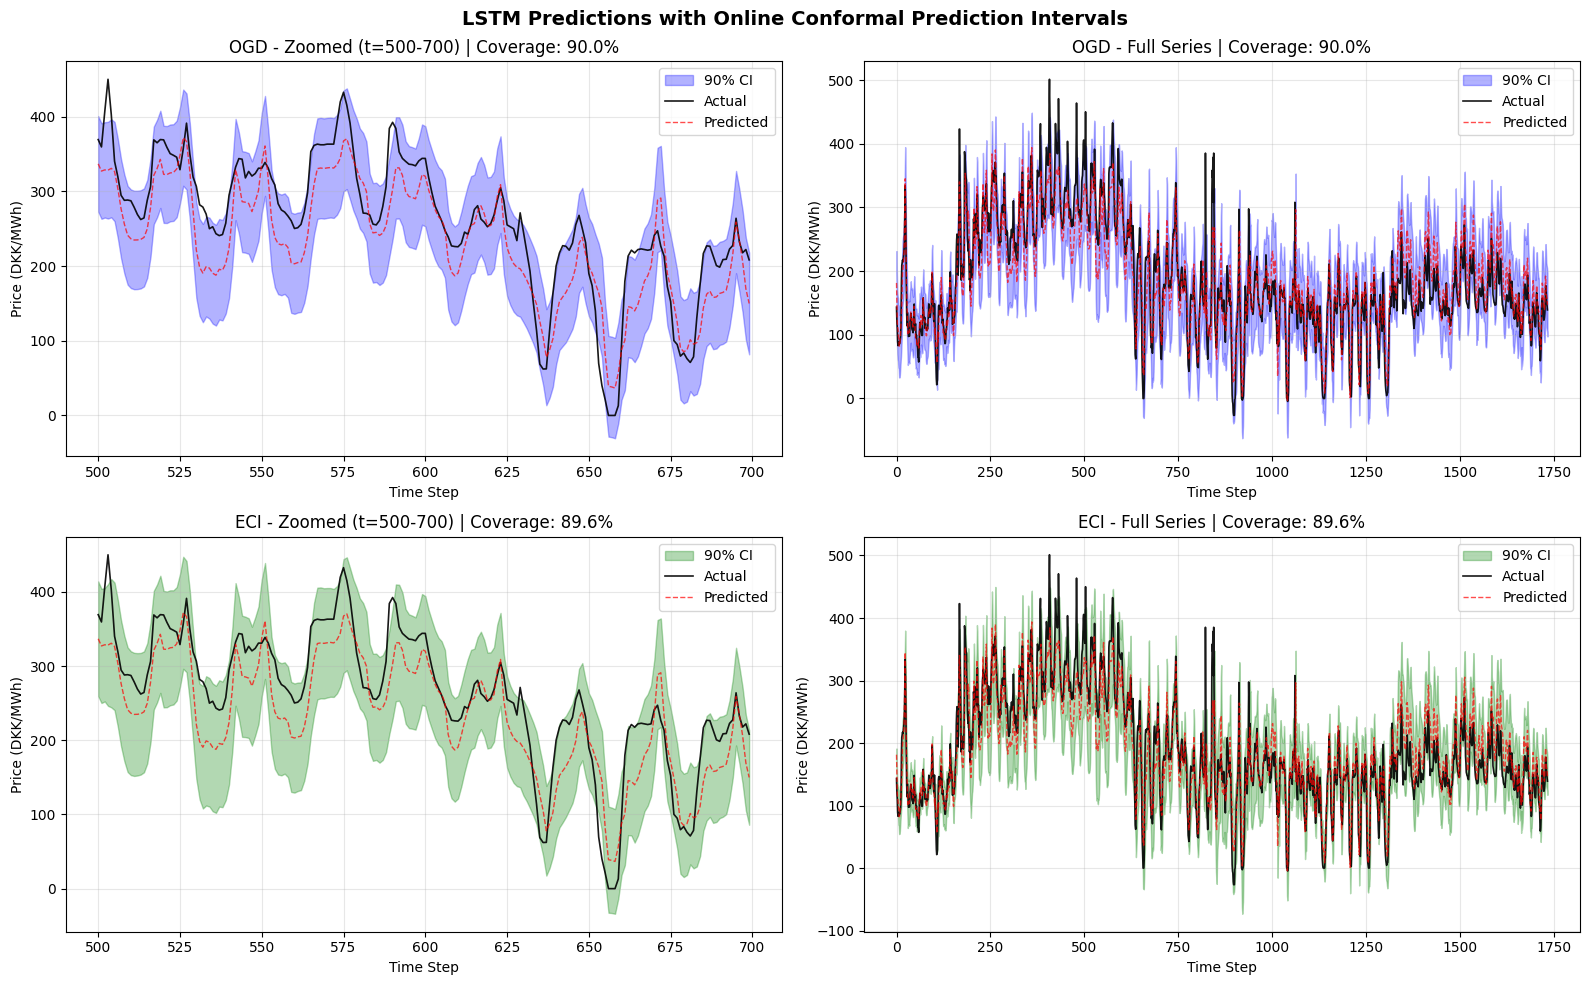

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def get_intervals_from_history(predictions, threshold_history, q_init):
    """Reconstruct intervals from threshold history.
    
    threshold_history[t] contains q AFTER the update at time t.
    The interval at time t uses the q value BEFORE the update (i.e., from t-1).
    """
    # At t=0, we use q_init; at t>0, we use q from previous step
    q_values = [q_init] + list(threshold_history[:-1])
    q_values = np.array(q_values)
    lowers = predictions - q_values
    uppers = predictions + q_values
    return lowers, uppers

# Get intervals for both methods
ogd_lower, ogd_upper = get_intervals_from_history(predictions_unscaled, ogd.threshold_history, q_init=50)
eci_lower, eci_upper = get_intervals_from_history(predictions_unscaled, eci.threshold_history, q_init=10)

# Define zoom window
zoom_start, zoom_end = 500, 700
time_steps = np.arange(len(predictions_unscaled))

# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

def plot_ci(ax, time_range, lower, upper, preds, actuals, title, color, is_zoomed=False):
    """Plot confidence interval on a given axis."""
    t = time_range
    ax.fill_between(t, lower[t], upper[t], alpha=0.3, color=color, label='90% CI')
    ax.plot(t, actuals[t], color='black', linewidth=1.2, label='Actual', alpha=0.9)
    ax.plot(t, preds[t], color='red', linewidth=1, label='Predicted', alpha=0.7, linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (DKK/MWh)')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

# OGD plots
ogd_coverage = ogd.get_coverage_rate()
plot_ci(axes[0, 0], range(zoom_start, zoom_end), ogd_lower, ogd_upper, 
        predictions_unscaled, actuals_unscaled, 
        f'OGD - Zoomed (t={zoom_start}-{zoom_end}) | Coverage: {ogd_coverage:.1%}', 'blue')

plot_ci(axes[0, 1], range(len(predictions_unscaled)), ogd_lower, ogd_upper,
        predictions_unscaled, actuals_unscaled,
        f'OGD - Full Series | Coverage: {ogd_coverage:.1%}', 'blue')

# ECI plots  
eci_coverage = eci.get_coverage_rate()
plot_ci(axes[1, 0], range(zoom_start, zoom_end), eci_lower, eci_upper,
        predictions_unscaled, actuals_unscaled,
        f'ECI - Zoomed (t={zoom_start}-{zoom_end}) | Coverage: {eci_coverage:.1%}', 'green')

plot_ci(axes[1, 1], range(len(predictions_unscaled)), eci_lower, eci_upper,
        predictions_unscaled, actuals_unscaled,
        f'ECI - Full Series | Coverage: {eci_coverage:.1%}', 'green')

plt.suptitle('LSTM Predictions with Online Conformal Prediction Intervals', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()